

# **Vision-Language Models**

Vision-language models bridge the gap between visual and textual modalities by enabling machines to generate natural language descriptions of images, answer questions about images, and perform other tasks that require an understanding of both vision and language. These models have revolutionized fields like image captioning, visual question answering (VQA), and multimodal retrieval by leveraging deep learning architectures such as CNNs and Transformers.

Among state-of-the-art approaches, **BLIP** (Bootstrapping Language-Image Pre-training) stands out as a powerful vision-language model. BLIP is trained with a combination of image and text data, learning rich representations that enable it to generate high-quality image captions, as well as perform other vision-language tasks.

# **Flickr8k Dataset**

The **Flickr8k** dataset contains 8,000 images, each accompanied by five textual descriptions provided by human annotators. The dataset is commonly used for image captioning tasks, where the goal is to train models to automatically generate captions for new images. Each caption focuses on key elements within the image, such as objects, actions, and interactions between objects.

# **Objective**

The objective of this project is to **fine-tune BLIP** on the **Flickr8k** dataset for the task of **image captioning**. By fine-tuning the pre-trained BLIP model, we aim to optimize it for generating accurate and coherent captions that describe the content of images in the Flickr8k dataset. The steps involved include:

- Preprocessing the Flickr8k dataset for compatibility with BLIP.
- Fine-tuning the BLIP model with the Flickr8k image-caption pairs.
- Evaluating the performance of the fine-tuned model using metrics such as BLEU, ROUGE, or CIDEr.



In [ ]:
!pip install transformers peft datasets nltk tqdm pillow matplotlib


### **Importing the Necessary Libraries**


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from PIL import Image
import os
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

nltk.download('punkt')
# 1. Set up the environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# # Load captions

captions_file = "/content/drive/MyDrive/captions.txt/captions.txt"
image_dir = "/content/drive/MyDrive/Images"

In [ ]:

captions_dict = {}
with open(captions_file, 'r') as f:
  lines = f.readlines()
  for line in lines[1:20000]:
        parts = line.strip().split(',', 1)
        if len(parts) == 2:
            image_file, caption = parts
            if image_file not in captions_dict:
                captions_dict[image_file] = caption
            # captions_dict[image_file].append(caption)

In [ ]:
#captions_dict


# **Loading BLIP Model and Processor for Image Captioning**

In [ ]:
# Load model and processor
model_id = "Salesforce/blip-image-captioning-base"

# Import the necessary class from transformers
from transformers import AutoModelForVision2Seq, AutoProcessor

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForVision2Seq.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)

### **Model Architecture and Training Objectives**

1. **Unimodal Encoder:**
   This component separately encodes images and text. The text encoder is based on BERT, utilizing a [CLS] token to summarize the sentence.

2. **Image-Grounded Text Encoder:**
   This encoder injects visual information by adding a cross-attention layer between the self-attention layer and the feed-forward network for each transformer block. A task-specific [Encode] token is appended, and its output serves as the multimodal representation of the image-text pair.

3. **Image-Grounded Text Decoder:**
   This decoder replaces bi-directional self-attention layers with causal self-attention layers. It uses a [Decode] token to indicate the start of a sequence and an end-of-sequence token to mark its conclusion.

   ### **Training Objectives**

- **Image-Text Contrastive Loss (ITC):** Aligns the feature spaces of visual and text transformers by encouraging similar representations for positive image-text pairs and contrasting them with negative pairs.

- **Image-Text Matching Loss (ITM):** Learns multimodal representations by predicting whether image-text pairs are matched or unmatched.

- **Language Modeling Loss (LM):** Generates textual descriptions from images.






### **PEFT (Parameter-Efficient Fine-Tuning)**

PEFT allows models to adapt to new tasks by updating only a subset of their parameters, making fine-tuning more efficient. Instead of retraining all parameters, only specific layers or parts of the model are fine-tuned, which is especially useful for large models.

### **LoRA (Low-Rank Adaptation)**

LoRA is a specific technique under PEFT that uses low-rank matrices to introduce task-specific updates to a model. It inserts trainable adapters into the model’s architecture, allowing the original pre-trained weights to remain largely unchanged while enabling the model to learn new tasks efficiently by adjusting only a small portion of the parameters.


### **LoRA Application in BLIP Components**

LoRA is applied in the following components within the BLIP architecture:

- **BlipVisionModel**
- **BlipTextModel**
- **BlipForConditionalGeneration = Image-Grounded Text Decoder**

During backpropagation, gradients are computed for the model parameters modified by LoRA. This allows for efficient updates without altering the entire model. The updates primarily affect the low-rank adaptation parameters in the layers where LoRA is implemented.

#### **Model Updates**

- **BlipVisionModel** and **BlipTextModel** are updated based on the Image-Text Contrastive Loss, which encourages better associations between images and their corresponding text.
- **BlipForConditionalGeneration** is updated based on the Language Modeling Loss, focusing on generating coherent and contextually relevant text from the visual input.


In [ ]:
from peft import LoraConfig # import LoraConfig from the peft module

# Configuration for PEFT
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "self.query",
        "self.key",
        "self.value",
        "output.dense",
        "self_attn.qkv",
        "self_attn.projection",
        "mlp.fc1",
        "mlp.fc2",
    ],
)


In [ ]:
from peft import LoraConfig, get_peft_model # import get_peft_model from the peft module

# Apply PEFT to the model
model = get_peft_model(model, config)
model.print_trainable_parameters()


trainable params: 5,455,872 || all params: 252,869,948 || trainable%: 2.1576


### **Preparing Data for Image Captioning**


In [ ]:
from torch.utils.data import Dataset # Import the Dataset class from torch.utils.data
import os # Import the os module
from PIL import Image # Import the Image module from PIL


class ImageCaptioningDataset(Dataset):
    def __init__(self, image_dir, captions_dict, processor):
        self.image_dir = image_dir
        self.captions_dict = captions_dict
        self.image_files = list(captions_dict.keys())
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert('RGB')
        caption = self.captions_dict[image_file]
        #caption = captions[0]  # Using the first caption for simplicity

        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = caption
        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [ ]:

# Create dataset
full_dataset = ImageCaptioningDataset(image_dir, captions_dict, processor)


In [ ]:
full_dataset[0]


{'pixel_values': tensor([[[-0.9456, -0.1280, -0.2448,  ..., -1.7339, -1.7047, -1.7193],
          [-1.0039, -0.1280, -0.2302,  ..., -1.6901, -1.6463, -1.7631],
          [-1.0477, -0.1280, -0.2010,  ..., -1.6755, -1.7193, -1.5587],
          ...,
          [ 0.7625,  0.5873,  0.6603,  ...,  0.7041,  0.6603,  0.6603],
          [ 0.9814,  1.7406,  1.9303,  ...,  0.6895,  0.6749,  0.6749],
          [ 1.0836,  1.3172,  0.9814,  ...,  0.6895,  0.6457,  0.6749]],
 
         [[-0.9117,  0.1989,  0.0939,  ..., -1.6921, -1.6470, -1.6470],
          [-0.9567,  0.1989,  0.1089,  ..., -1.6170, -1.5420, -1.6771],
          [-1.0167,  0.1689,  0.1389,  ..., -1.6170, -1.6170, -1.4069],
          ...,
          [-0.4914, -0.2813,  0.2139,  ...,  1.0243,  0.9943,  1.0243],
          [-0.5215,  1.3245,  1.7147,  ...,  1.0393,  1.0093,  1.0093],
          [-0.2813,  0.3640, -0.3114,  ...,  1.0393,  1.0093,  0.9943]],
 
         [[-0.3995,  0.3399,  0.1835,  ..., -1.4376, -1.4091, -1.4376],
          [-

In [ ]:
from torch.utils.data import Dataset, random_split # Import the random_split function from torch.utils.data

# Split the dataset into training and validation sets
train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)


(3400, 600)

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split # Import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=10, collate_fn=collate_fn)

In [ ]:
#Import the AdamW optimizer from torch.optim
from transformers import AdamW
# Setup optimizer
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): BlipForConditionalGeneration(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-11): 12 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=2304, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=2304, bias=False)
                  

### **Training Loop**


Epoch 1/5
Average Loss for Epoch 1: 4.6818
Average Validation Loss for Epoch 1: 4.3275
Epoch 2/5
Average Loss for Epoch 2: 4.2569
Average Validation Loss for Epoch 2: 4.2866
Epoch 3/5
Average Loss for Epoch 3: 4.1176
Average Validation Loss for Epoch 3: 4.2896
Epoch 4/5
Average Loss for Epoch 4: 4.0615
Average Validation Loss for Epoch 4: 4.3019
Epoch 5/5
Average Loss for Epoch 5: 3.9526
Average Validation Loss for Epoch 5: 4.3362


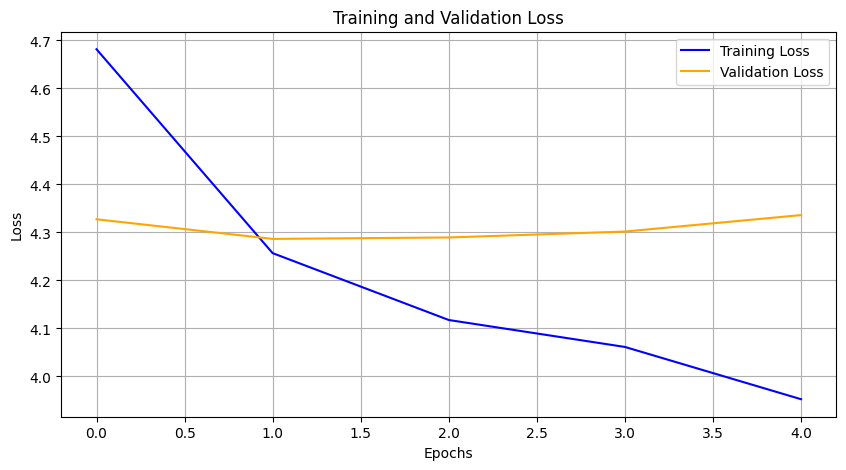

In [ ]:
import matplotlib.pyplot as plt

# Lists to store the losses
train_losses = []
val_losses = []

# Training loop
model.train()
for epoch in range(5):  # Changed to 10 epochs
    print(f"Epoch {epoch + 1}/{5}")
    epoch_loss = 0
    for batch in train_dataloader:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_mask = batch.pop("attention_mask").to(device)

        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            labels=input_ids,
            attention_mask=attention_mask,
        )

        loss = outputs.loss

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss. Skipping batch.")
            continue

        epoch_loss += loss.item()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()

    avg_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_loss)  # Append train loss
    print(f"Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No gradients needed for validation
        for batch in val_dataloader:
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            attention_mask = batch.pop("attention_mask").to(device)

            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                labels=input_ids,
                attention_mask=attention_mask,
            )

            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # Append validation loss
    print(f"Average Validation Loss for Epoch {epoch + 1}: {avg_val_loss:.4f}")

# Save the fine-tuned model
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/LLM Projects/Finetuned_blip/caption')

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


### **Generating and Visualizing Image Captions**


In [ ]:

# Load the fine-tuned model and processor
model_id = "Salesforce/blip-image-captioning-base"
# Updated model path to point to the directory where the model was saved
model_path = '/content/drive/MyDrive/Colab Notebooks/LLM Projects/Finetuned_blip/caption'
finetuned_model = AutoModelForVision2Seq.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating captions with finetuned model:


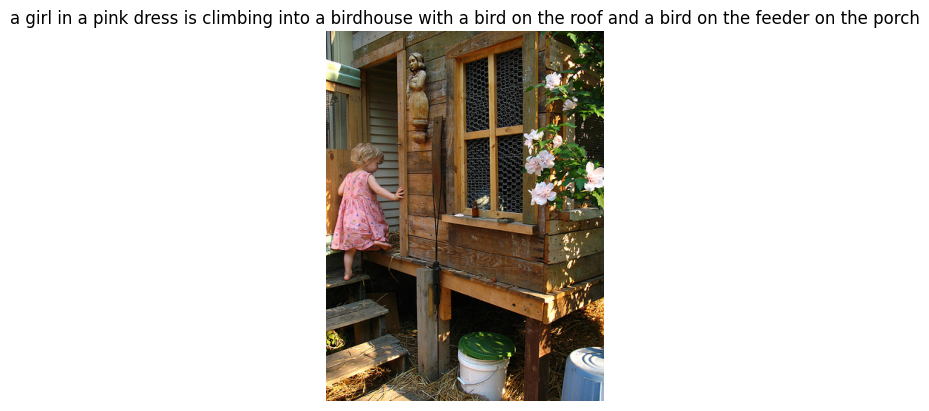

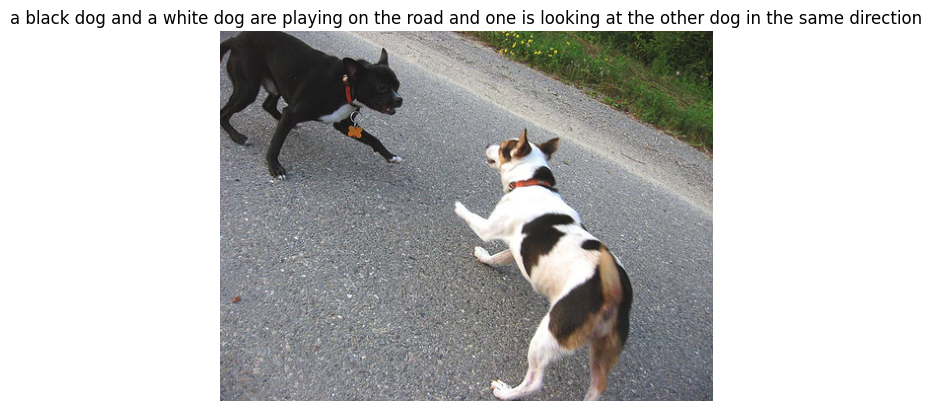

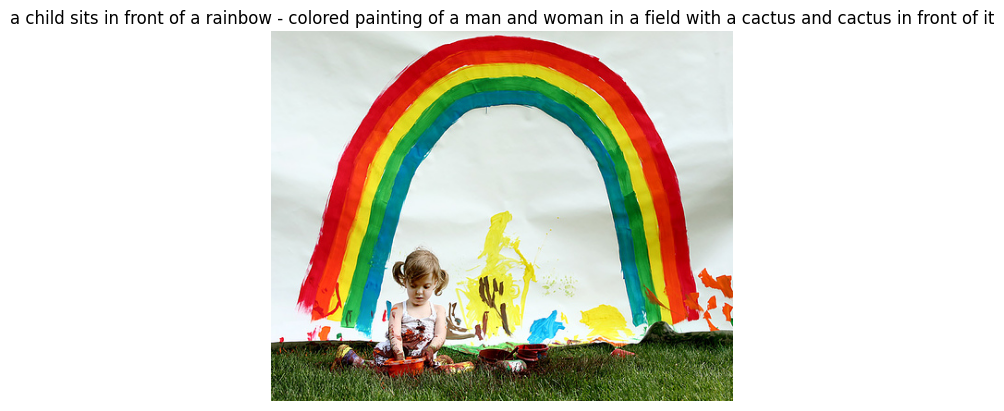

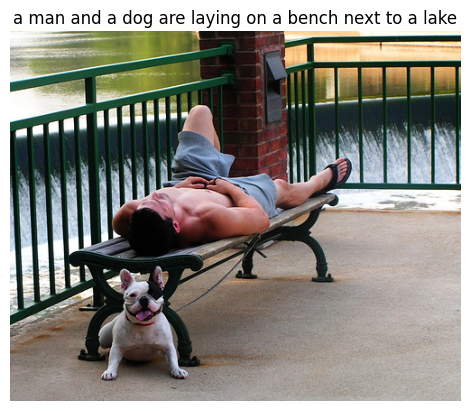

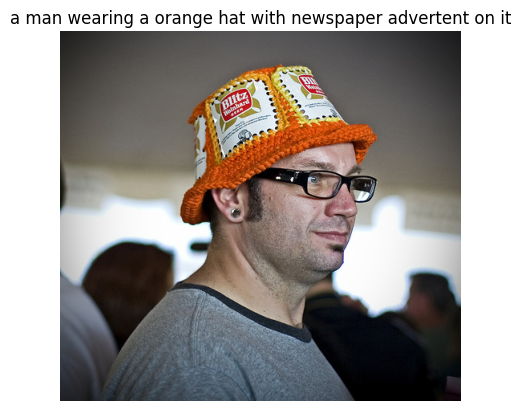

In [ ]:

import matplotlib.pyplot as plt
import torch
from PIL import Image
import os

def visualize_image_with_caption(image_path, caption):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

def generate_and_plot_captions(model, processor, image_dir, captions_dict, device, num_images=5):
    model.eval()
    images = list(captions_dict.keys())[:num_images]
    with torch.no_grad():
        for image_file in images:
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path).convert('RGB')
            pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
            generated_output = model.generate(pixel_values=pixel_values, max_new_tokens=64)
            generated_caption = processor.batch_decode(generated_output, skip_special_tokens=True)[0]
            visualize_image_with_caption(image_path, generated_caption)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
finetuned_model.to(device)

# Generate and plot captions after finetuning
print("Generating captions with finetuned model:")
generate_and_plot_captions(finetuned_model, processor, image_dir, captions_dict, device)